In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.lib.plotting
# Set up parallelization
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

<ipython-input-1-5b648b8aa98d>:24: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


In [2]:
def cgi_region(clr,region):
    cg = adaptive_coarsegrain(clr.matrix(balance=True).fetch(region),
                              clr.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)
    cgi = interp_nan(cg)
    return(cgi)

def _extract_profile(chrom, clr, clr_weight_name, viewpoint):
    to_return = []
    if clr_weight_name:
        colname = "balanced"
    else:
        colname = "count"
    pxls1 = clr.matrix(balance=clr_weight_name, as_pixels=True, join=True).fetch(
        chrom, viewpoint
    )
    pxls1[["chrom2"]] = viewpoint[0]
    pxls1[["start2"]] = viewpoint[1]
    pxls1[["end2"]] = viewpoint[2]

    pxls1 = (
        pxls1.groupby(["chrom1", "start1", "end1"], observed=True)[colname]
        .mean()
        .reset_index()
    )
    pxls1.columns = ["chrom", "start", "end", colname]
    if pxls1.shape[0] > 0:
        to_return.append(pxls1)

    pxls2 = clr.matrix(balance=clr_weight_name, as_pixels=True, join=True).fetch(
        viewpoint, chrom
    )
    pxls2[["chrom1"]] = viewpoint[0]
    pxls2[["start1"]] = viewpoint[1]
    pxls2[["end1"]] = viewpoint[2]
    pxls2 = (
        pxls2.groupby(["chrom2", "start2", "end2"], observed=True)[colname]
        .mean()
        .reset_index()
    )
    pxls2.columns = ["chrom", "start", "end", colname]
    if pxls2.shape[0] > 0:
        to_return.append(pxls2)

    if len(to_return) > 0:
        return pd.concat(to_return, ignore_index=True)

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)


In [3]:
res = '2000'
clr_ctr = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_'+res+'_raw.cool')
clr_dpy27 = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK11_JK12_combined_30_'+res+'_raw.cool')

clrs = [clr_ctr,clr_dpy27]


In [4]:
rex_strong = bioframe.read_table("/scratch/cgsb/ercan/Jun_annot/sarah_strong_bed3.bed",schema='bed3')

viewpoint = rex_strong.iloc[14,:]
viewpoint

chrom           X
start    16056339
end      16056740
Name: 14, dtype: object

In [6]:
viewpoint_bedgraph = _extract_profile(chrom=viewpoint['chrom'],clr=clrs[0],viewpoint=viewpoint,clr_weight_name=True)
viewpoint_bedgraph

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,chrom,start,end,balanced
0,X,42000,44000,0.000168
1,X,90000,92000,0.000153
2,X,170000,172000,NaN
3,X,278000,280000,NaN
4,X,298000,300000,0.000148
...,...,...,...,...
1953,X,17706000,17708000,0.000112
1954,X,17712000,17714000,0.000205
1955,X,17714000,17716000,0.000062
1956,X,17716000,17718000,0.000149


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


chrom           X
start    16056339
end      16056740
Name: 14, dtype: object


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


chrom           X
start    16056339
end      16056740
Name: 14, dtype: object


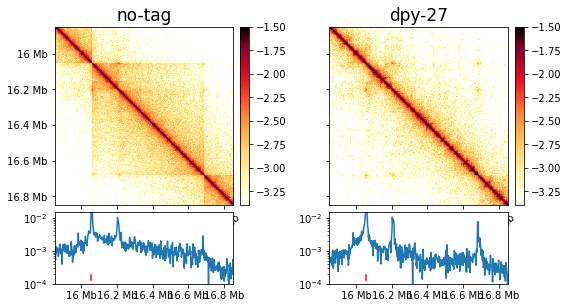

In [9]:

f, axs = plt.subplots(
    figsize=(8, 6),
    nrows=1,
    ncols=2,
    sharex='col',
    sharey='row'
)

region = 'X:15,850,000-16,850,000'
start, end = 15_850_000, 16_850_000
extents = (start, end, end, start)

clrs
vp = viewpoint
sub_titles = ['no-tag','dpy-27']

minmax_o = [-3.4,-1.5] 
minmax_vp = [0.0001,0.015]
############# plot regular HiC ###############
for i in range(len(clrs)): 
    ax = axs[i]
    clr_region = cgi_region(clrs[i],region) 
    im = ax.matshow(
        np.log10(clr_region), 
        cmap='fall', # 
        vmin=minmax_o[0],vmax=minmax_o[1], 
        extent=extents
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1) 
    plt.colorbar(im, cax=cax)
    
    ############## view point #######
    ax_vp = divider.append_axes("bottom", size="40%", pad=0.1, sharex=ax)
    print(vp)

    vp_bedgraph = _extract_profile(chrom=vp['chrom'],clr=clrs[i],viewpoint=vp,clr_weight_name=True)
    vp_region = bioframe.select(vp_bedgraph, region)
    
    xval=vp_region[['start', 'end']].mean(axis=1)
    yval=np.array(vp_region['balanced'],dtype=float)
    mask = np.isfinite(yval)
    
    ax_vp.semilogy(xval[mask], yval[mask])
    ax_vp.set_ylim(minmax_vp[0],minmax_vp[1])
    
    ######### annotate viewpoint #######
    annot_vp = (vp['start']+vp['end'])/2
    ax_vp.axvline(x=annot_vp,ymin=0.05,ymax=0.12,c="red",alpha=1)
    
    #### asthetics ###
    
for i in range(2):
    axs[i].set_title(sub_titles[i],fontsize=17) # put titles
    
    format_ticks(axs[i]) # convert scientific notation to mb units
    
plt.tight_layout()    